In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

# for loading MNIST data
from torchvision import transforms, datasets

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [3]:
# if cuda device is available then run model on gpu
if torch.cuda.is_available():
    cuda_flag=True
else:
    cuda_flag=False
    
torch.manual_seed(3120)

### Setting up data loader

In [4]:
batch_size=64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])])

train_loader = torch.utils.data.DataLoader(
                datasets.MNIST('./dataset/', train=True, download=True,transform=transforms.ToTensor()),
                batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
                datasets.MNIST('./dataset/', train=False, download=True, transform=transforms.ToTensor()),
                 batch_size=batch_size)

### Class definition for encoder decoder networks

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_dim, z_dim):
        super(Encoder, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.shared_fc1 = nn.Linear(in_features=2*input_dim, out_features=z_dim*8)
        self.shared_fc2 = nn.Linear(in_features=z_dim*8, out_features=z_dim*4)
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        self.mu = nn.Linear(z_dim*4, z_dim)
        self.var = nn.Linear(z_dim*4, z_dim)
        

    def forward(self, x):
        x = x.view(len(x),1,28,28)
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
    
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        
        x = x.view(len(x),-1)
        x = F.relu(self.shared_fc1(x))
        x = F.relu(self.shared_fc2(x))
        z_mu = self.mu(x)
        z_var = self.var(x)

        return z_mu, z_var
    
class Decoder(nn.Module):
    def __init__(self, output_dim, z_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=z_dim, out_features=z_dim*4)
        self.fc2 = nn.Linear(in_features=z_dim*4, out_features=z_dim*16)
        self.fc3 = nn.Linear(in_features=z_dim*16, out_features=output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [6]:
class VAE(nn.Module):
    def __init__(self, enc, dec, z_dim):
        super(VAE, self).__init__()
        
        self.enc = enc
        self.dec = dec
        
    def forward(self,x):
        z_mu,z_logvar = self.enc(x)
        
        # sample z using the mean and variance obtained from encoder
        std = torch.exp(0.5*z_logvar)
        eps = torch.randn_like(std)
        z = z_mu + eps*std
        
        predicted = self.dec(z)
        return predicted, z_mu, z_logvar

In [7]:
def crit(y_pred, y, z_mu, z_logvar):
    reconstruction_loss = F.binary_cross_entropy(y_pred, y, reduction='sum')
    
    kl_divergence = -0.5 * torch.sum(1 + z_logvar - z_mu.pow(2) - z_logvar.exp())
    
    return reconstruction_loss+kl_divergence

In [8]:
def plot_tensor_img(x):
    fig = plt.figure(figsize=(10,1))
    generated_images = x.detach().cpu().numpy().reshape(len(x),28,28)
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.imshow(generated_images[i])
    plt.show()

In [9]:
# instantiate the models
enc = Encoder(input_dim=784, z_dim=32)
dec = Decoder(output_dim=784, z_dim=32)

model = VAE(enc, dec, 32)

if cuda_flag:
    model = model.cuda()

In [10]:
lr = 1e-3
opt = optim.Adam(model.parameters(), lr=lr)

In [11]:
epochs = 15
loss_history = []

sample_images = next(iter(test_loader))[0]

True Images


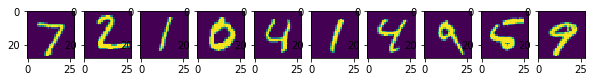

Epoch:0 Train Loss:181.114
Reconstructed Images after Epoch  0


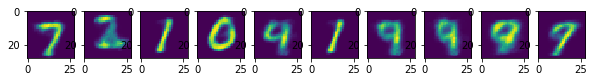

Epoch:1 Train Loss:134.675
Epoch:2 Train Loss:123.724
Epoch:3 Train Loss:119.378
Reconstructed Images after Epoch  3


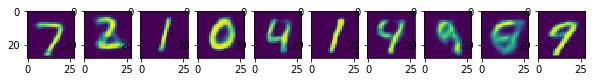

Epoch:4 Train Loss:116.526
Epoch:5 Train Loss:113.627
Epoch:6 Train Loss:111.371
Reconstructed Images after Epoch  6


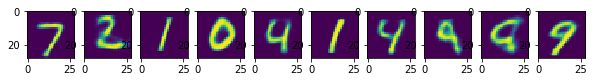

Epoch:7 Train Loss:110.039
Epoch:8 Train Loss:109.085
Epoch:9 Train Loss:108.303
Reconstructed Images after Epoch  9


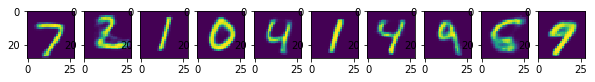

Epoch:10 Train Loss:107.686
Epoch:11 Train Loss:107.186
Epoch:12 Train Loss:106.674
Reconstructed Images after Epoch  12


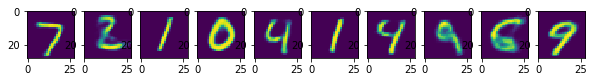

Epoch:13 Train Loss:106.277
Epoch:14 Train Loss:105.858



In [12]:
print("True Images")
plot_tensor_img(sample_images)

for epoch in tqdm(range(epochs)):
    train_loss=0
    
    # iterate over dataset
    for x,_ in train_loader:
        x = x.view(len(x),-1)
        # move data to gpu if cuda_flag is set
        if cuda_flag:
            x = x.cuda()
        
        # zero_grad to ensure no unaccounted calculation creeps in while calculating gradients
        opt.zero_grad()
        
        # forward propogation and loss computation
        x_gen, z_mu, z_logvar = model(x)
        loss = crit(x_gen,x, z_mu, z_logvar)
        train_loss+=loss.item()
        
        # backpropogate gradients
        loss.backward()
        
        # update weights
        opt.step()
    train_loss/=len(train_loader)*batch_size

    print ("Epoch:{} Train Loss:{:.6}".format(epoch,train_loss))
    loss_history.append(train_loss)
    
    if epoch%3==0:
        print("Reconstructed Images after Epoch ",epoch)
        with torch.no_grad():
            x = sample_images.view(len(sample_images),-1)
            # move data to gpu if cuda_flag is set
            if cuda_flag:
                x = x.cuda()

            # forward propogation and loss computation
            x_gen, _, _ = model(x)
            plot_tensor_img(x_gen)

### New Image Generation using Decoder

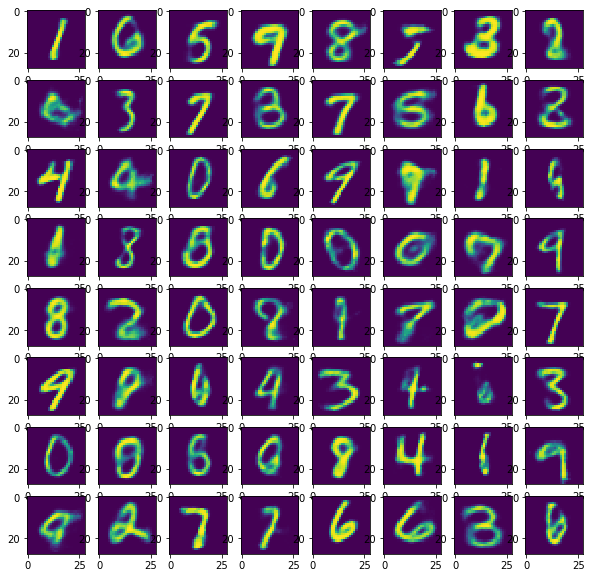

In [13]:
# sample random tensors using standard multivariate normal distribution
z = torch.randn(64,32)
if cuda_flag:
    z = z.cuda()

# pass the random tensors through decoder to generate the new images
with torch.no_grad():
    generated_images = model.dec(z).cpu().numpy().reshape(len(z),28,28)

fig = plt.figure(figsize=(10,10))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(generated_images[i])
plt.show()